In [1]:
%matplotlib inline
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_rows = 200

plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('font', size=20)



# Loading Dataset

## IOT Devices

The dataset has been extracted at `ROOT_PATH`, containing the data for each IOT device. There are 9 devices in total. There are folders for each IOT device containing `benign_traffic.csv` and further two folders for `gafgyt_attacks` and `mirai_attacks`

In [7]:
ROOT_PATH = r'C:\Users\jessm\Desktop\HonoursProject\N-BaIoT_Dataset'
IOT_DEVS = [ 'Danmini_Doorbell',
             'Ecobee_Thermostat',
             'Ennio_Doorbell',
             'Philips_Baby_Monitor',
             'Samsung_Webcam',
             '737E_Security_Cam',
             '838_Security_Cam',
            '1002_Security_Cam',
             '1003_Security_Cam'
           ]

## Paths to CSVs
We create a python dictionary that contains all the paths to the CSVs for the respective IOT devices

In [8]:
PATHS_DICT = {}

for i in IOT_DEVS:
    PATHS_DICT[i] = {}
    print('[' + i + ']')
    iot_dir = os.path.join(ROOT_PATH, i)
    PATHS_DICT[i]['benign'] = os.path.join(iot_dir, 'benign_traffic.csv')
    print('  ', 'benign_traffic.csv')
    attacks = [ d for d in os.listdir(iot_dir)
                   if os.path.isdir( os.path.join(iot_dir, d)) ]
    for attack in attacks:
        attack_name = attack.split('_')[0]
        
        PATHS_DICT[i][attack_name] = {}
        attack_dir = os.path.join(iot_dir, attack)
        types = [ f for f in os.listdir(attack_dir)
                   if os.path.isfile( os.path.join(attack_dir, f)) ]
        print('  ', attack_name, ': ', types)
        for t in types:
            type_name = t.split('.')[0]
            PATHS_DICT[i][attack_name][type_name] = os.path.join(attack_dir,t)

[Danmini_Doorbell]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[Ecobee_Thermostat]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[Ennio_Doorbell]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
[Philips_Baby_Monitor]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[Samsung_Webcam]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
[737E_Security_Cam]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[838_Security_Cam]

## Loading CSVs into Pandas
We will create pandas dataframe for each botnet attack on each IOT device. For each datafram we will combine the attack traffic with the benign traffic add the following two columns:
- `traffic_type` : benign or attack (0 or 1)
- `attack_type`  : type of attack e.g, ack, scan etc.

In [9]:
nbaiot_dict = {}

for iot_dev in PATHS_DICT:
    nbaiot_dict[iot_dev] = {}
    
    b_df = pd.read_csv(PATHS_DICT[iot_dev]['benign'])
    b_df['traffic_type'] = 'benign'
    b_df['attack_type'] = 'benign'
    
    for botnet in [b for b in PATHS_DICT[iot_dev] if b != 'benign']:
        nbaiot_dict[iot_dev][botnet] = pd.concat([b_df], ignore_index=True)
        
        for attack in PATHS_DICT[iot_dev][botnet]:
            a_df = pd.read_csv(PATHS_DICT[iot_dev][botnet][attack])
            a_df['traffic_type'] = 'attack'
            a_df['attack_type'] = attack
            nbaiot_dict[iot_dev][botnet] = pd.concat([nbaiot_dict[iot_dev][botnet], a_df], ignore_index=True)

In [10]:
for k in nbaiot_dict:
    print(k)
    for b in nbaiot_dict[k]:
        print('  ',b,':','<benign+attack>')

Danmini_Doorbell
   gafgyt : <benign+attack>
   mirai : <benign+attack>
Ecobee_Thermostat
   gafgyt : <benign+attack>
   mirai : <benign+attack>
Ennio_Doorbell
   gafgyt : <benign+attack>
Philips_Baby_Monitor
   gafgyt : <benign+attack>
   mirai : <benign+attack>
Samsung_Webcam
   gafgyt : <benign+attack>
737E_Security_Cam
   gafgyt : <benign+attack>
   mirai : <benign+attack>
838_Security_Cam
   gafgyt : <benign+attack>
   mirai : <benign+attack>
1002_Security_Cam
   gafgyt : <benign+attack>
   mirai : <benign+attack>
1003_Security_Cam
   gafgyt : <benign+attack>
   mirai : <benign+attack>


# Modeling

### Pre processing
Convert the target column `traffic_type` to integer 0 = benigh, 1 = attack 

In [11]:
for dev in nbaiot_dict:
    for botnet in nbaiot_dict[dev]:
        nbaiot = nbaiot_dict[dev][botnet]

        nbaiot.loc[ nbaiot['traffic_type']=='attack','traffic_type' ]=1
        nbaiot.loc[ nbaiot['traffic_type']=='benign','traffic_type' ]=0
        nbaiot['traffic_type'] = nbaiot['traffic_type'].astype(int)
        
        nbaiot_dict[dev][botnet] = nbaiot

### Classifiers and training functions

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [13]:
#Initilaize dictionary called classifiers with ML classifiers to be used
classfiers = {
    'KNN' : KNeighborsClassifier(),
    'RFR' : RandomForestClassifier(),
    'DTR' : DecisionTreeClassifier(),
    'ADB' : AdaBoostClassifier(),
    
}
#train_test_split function from scikit-learn to split the dataset into training and testing sets.

def train_test_report( X, y, test_size=0.33, avg='macro avg' ):

    X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.33, random_state=42)

    result = []
    for clf_name in classfiers:
        clf = classfiers[clf_name]
        clf.fit(X_train, y_train)
        
        y_preds = clf.predict(X_test)
        
        clrp = classification_report(y_test, y_preds, output_dict=True)
        conf_mat = confusion_matrix(y_test, y_preds)
        fp = conf_mat[0][1]
        fn = conf_mat[1][0]
        
        result.append([
            clf_name,
            clrp['accuracy'],
            clrp[avg]['precision'],
            clrp[avg]['recall'],
            clrp[avg]['f1-score'],
            fp,
            fn
        ])

    return result

## Main Loop

In [14]:
all_results = [
    ['DEVICE','BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'RECALL', 'F1-SCORE', 'FALSE-P', 'FALSE-N' ]
]
for dev in nbaiot_dict:
    for botnet in nbaiot_dict[dev]:
        nbaiot = nbaiot_dict[dev][botnet]
        
        print("================", dev, "/", botnet, "================")

        X = nbaiot.drop( ["attack_type", "traffic_type" ], axis=1 )
        y = nbaiot["traffic_type"]

        rep = train_test_report( X, y)
        for r in rep:
            print(r)
            all_results.append( [dev, botnet] + r )

        print("================================================================")
        print("")
        

================ Danmini_Doorbell / gafgyt ================
['KNN', 0.9983781010542343, 0.9958236432018861, 0.9972949612517443, 0.9965577251288404, 69, 127]
['RFR', 0.9999834500107575, 0.9999648226132871, 0.9999648226132871, 0.9999648226132871, 1, 1]
['DTR', 0.9999586250268937, 0.9999248520312785, 0.9998992574789141, 0.9999120542819608, 3, 2]
['ADB', 0.9999751750161362, 0.9999088533754633, 0.9999856310828417, 0.9999472379716858, 0, 3]

================ Danmini_Doorbell / mirai ================
['KNN', 0.9986093355906437, 0.9939346519707908, 0.9954962951818089, 0.9947140200243505, 133, 189]
['RFR', 0.9999913623328611, 0.9999388865122533, 0.9999953527927392, 0.9999671177741546, 0, 2]
['DTR', 0.9999870434992917, 0.9999083353703251, 0.9999930291891088, 0.9999506780538334, 0, 3]
['ADB', 0.9999870434992917, 0.9999083353703251, 0.9999930291891088, 0.9999506780538334, 0, 3]

================ Ecobee_Thermostat / gafgyt ================
['KNN', 0.9987831816990528, 0.9954461508552326, 0.988879518

In [15]:
res_df =pd.DataFrame(all_results, index=None)

res_df, res_df.columns = res_df[1:] , res_df.iloc[0]

res_df

,DEVICE,BOTNET,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1-SCORE,FALSE-P,FALSE-N
1,Danmini_Doorbell,gafgyt,KNN,0.998378,0.995824,0.997295,0.996558,69,127
2,Danmini_Doorbell,gafgyt,RFR,0.999983,0.999965,0.999965,0.999965,1,1
3,Danmini_Doorbell,gafgyt,DTR,0.999959,0.999925,0.999899,0.999912,3,2
4,Danmini_Doorbell,gafgyt,ADB,0.999975,0.999909,0.999986,0.999947,0,3
5,Danmini_Doorbell,mirai,KNN,0.998609,0.993935,0.995496,0.994714,133,189
6,Danmini_Doorbell,mirai,RFR,0.999991,0.999939,0.999995,0.999967,0,2
7,Danmini_Doorbell,mirai,DTR,0.999987,0.999908,0.999993,0.999951,0,3
8,Danmini_Doorbell,mirai,ADB,0.999987,0.999908,0.999993,0.999951,0,3
9,Ecobee_Thermostat,gafgyt,KNN,0.998783,0.995446,0.98888,0.992139,95,35
10,Ecobee_Thermostat,gafgyt,RFR,0.999963,0.99976,0.99976,0.99976,2,2


In [13]:
# Write to csv
res_csv = res_df.to_csv(index=False)

print(res_csv, file=open('02_results.csv', 'w'))


### Load results from CSV

In [14]:
res_df = pd.read_csv('02_results.csv')

res_df = res_df[['DEVICE', 'BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'FALSE-P', 'FALSE-N' ]]

res_df

,DEVICE,BOTNET,CLASSIFIER,ACCURACY,PRECISION,FALSE-P,FALSE-N
0,Danmini_Doorbell,gafgyt,KNN,0.998378,0.995824,69,127
1,Danmini_Doorbell,gafgyt,RFR,0.999992,0.999995,1,0
2,Danmini_Doorbell,gafgyt,DTR,0.999967,0.999955,3,1
3,Danmini_Doorbell,gafgyt,ADB,0.999975,0.999909,0,3
4,Danmini_Doorbell,mirai,KNN,0.998609,0.993935,133,189
5,Danmini_Doorbell,mirai,RFR,0.999996,0.999969,0,1
6,Danmini_Doorbell,mirai,DTR,0.999987,0.999908,0,3
7,Danmini_Doorbell,mirai,ADB,0.999987,0.999908,0,3
8,Ecobee_Thermostat,gafgyt,KNN,0.998783,0.995446,95,35
9,Ecobee_Thermostat,gafgyt,RFR,0.999981,0.999990,2,0


In [15]:
res_df.set_index(['DEVICE', 'BOTNET', 'CLASSIFIER'], inplace=True)
res_df

ACCURACY  PRECISION  FALSE-P  FALSE-N
DEVICE               BOTNET CLASSIFIER                                       
Danmini_Doorbell     gafgyt KNN         0.998378   0.995824       69      127
                            RFR         0.999992   0.999995        1        0
                            DTR         0.999967   0.999955        3        1
                            ADB         0.999975   0.999909        0        3
                     mirai  KNN         0.998609   0.993935      133      189
                            RFR         0.999996   0.999969        0        1
                            DTR         0.999987   0.999908        0        3
                            ADB         0.999987   0.999908        0        3
Ecobee_Thermostat    gafgyt KNN         0.998783   0.995446       95       35
                            RFR         0.999981   0.999990        2        0
                            DTR         0.999953   0.999424        0        5
                            ADB         0.999981   0.999990        2        0
                     mirai  KNN         0.999267   0.996645      101       26
                            RFR         0.999994   0.999885        0        1
                            DTR         0.999994   0.999885        0        1
                            ADB         0.999994   0.999885        0        1
Ennio_Doorbell       gafgyt KNN         0.998057   0.993740       75      153
                            RFR         0.999966   0.999947        3        1
                            DTR         0.999940   0.999864        4        3
                            ADB         0.999923   0.999889        7        2
Philips_Baby_Monitor gafgyt KNN         0.998168   0.997561       26      269
                            RFR         0.999963   0.999952        1        5
                            DTR         0.999876   0.999854        7       13
                            ADB         0.999950   0.999931        0        8
                     mirai  KNN         0.993604   0.994198     1391      268
                            RFR         0.999992   0.999983        0        2
                            DTR         0.999996   0.999991        0        1
                            ADB         0.999996   0.999991        0        1
Samsung_Webcam       gafgyt KNN         0.997464   0.993144       91      223
                            RFR         0.999976   0.999913        0        3
                            DTR         0.999943   0.999845        2        5
                            ADB         0.999992   0.999971        0        1

In [16]:
res_df0 = res_df.unstack(level=1)
res_df0

ACCURACY           PRECISION            \
BOTNET                             gafgyt     mirai    gafgyt     mirai   
DEVICE               CLASSIFIER                                           
Danmini_Doorbell     ADB         0.999975  0.999987  0.999909  0.999908   
                     DTR         0.999967  0.999987  0.999955  0.999908   
                     KNN         0.998378  0.998609  0.995824  0.993935   
                     RFR         0.999992  0.999996  0.999995  0.999969   
Ecobee_Thermostat    ADB         0.999981  0.999994  0.999990  0.999885   
                     DTR         0.999953  0.999994  0.999424  0.999885   
                     KNN         0.998783  0.999267  0.995446  0.996645   
                     RFR         0.999981  0.999994  0.999990  0.999885   
Ennio_Doorbell       ADB         0.999923       NaN  0.999889       NaN   
                     DTR         0.999940       NaN  0.999864       NaN   
                     KNN         0.998057       NaN  0.993740       NaN   
                     RFR         0.999966       NaN  0.999947       NaN   
Philips_Baby_Monitor ADB         0.999950  0.999996  0.999931  0.999991   
                     DTR         0.999876  0.999996  0.999854  0.999991   
                     KNN         0.998168  0.993604  0.997561  0.994198   
                     RFR         0.999963  0.999992  0.999952  0.999983   
Samsung_Webcam       ADB         0.999992       NaN  0.999971       NaN   
                     DTR         0.999943       NaN  0.999845       NaN   
                     KNN         0.997464       NaN  0.993144       NaN   
                     RFR         0.999976       NaN  0.999913       NaN   

                                FALSE-P         FALSE-N         
BOTNET                           gafgyt   mirai  gafgyt  mirai  
DEVICE               CLASSIFIER                                 
Danmini_Doorbell     ADB            0.0     0.0     3.0    3.0  
                     DTR            3.0     0.0     1.0    3.0  
                     KNN           69.0   133.0   127.0  189.0  
                     RFR            1.0     0.0     0.0    1.0  
Ecobee_Thermostat    ADB            2.0     0.0     0.0    1.0  
                     DTR            0.0     0.0     5.0    1.0  
                     KNN           95.0   101.0    35.0   26.0  
                     RFR            2.0     0.0     0.0    1.0  
Ennio_Doorbell       ADB            7.0     NaN     2.0    NaN  
                     DTR            4.0     NaN     3.0    NaN  
                     KNN           75.0     NaN   153.0    NaN  
                     RFR            3.0     NaN     1.0    NaN  
Philips_Baby_Monitor ADB            0.0     0.0     8.0    1.0  
                     DTR            7.0     0.0    13.0    1.0  
                     KNN           26.0  1391.0   269.0  268.0  
                     RFR            1.0     0.0     5.0    2.0  
Samsung_Webcam       ADB            0.0     NaN     1.0    NaN  
                     DTR            2.0     NaN     5.0    NaN  
                     KNN           91.0     NaN   223.0    NaN  
                     RFR            0.0     NaN     3.0    NaN

In [17]:
res_df1 = res_df0.unstack(level=1)
res_df1

ACCURACY                                          \
BOTNET                  gafgyt                                   mirai   
CLASSIFIER                 ADB       DTR       KNN       RFR       ADB   
DEVICE                                                                   
Danmini_Doorbell      0.999975  0.999967  0.998378  0.999992  0.999987   
Ecobee_Thermostat     0.999981  0.999953  0.998783  0.999981  0.999994   
Ennio_Doorbell        0.999923  0.999940  0.998057  0.999966       NaN   
Philips_Baby_Monitor  0.999950  0.999876  0.998168  0.999963  0.999996   
Samsung_Webcam        0.999992  0.999943  0.997464  0.999976       NaN   

                                                   PRECISION            ...  \
BOTNET                                                gafgyt            ...   
CLASSIFIER                 DTR       KNN       RFR       ADB       DTR  ...   
DEVICE                                                                  ...   
Danmini_Doorbell      0.999987  0.998609  0.999996  0.999909  0.999955  ...   
Ecobee_Thermostat     0.999994  0.999267  0.999994  0.999990  0.999424  ...   
Ennio_Doorbell             NaN       NaN       NaN  0.999889  0.999864  ...   
Philips_Baby_Monitor  0.999996  0.993604  0.999992  0.999931  0.999854  ...   
Samsung_Webcam             NaN       NaN       NaN  0.999971  0.999845  ...   

                     FALSE-P      FALSE-N                                      \
BOTNET                 mirai       gafgyt                   mirai               
CLASSIFIER               KNN  RFR     ADB   DTR    KNN  RFR   ADB  DTR    KNN   
DEVICE                                                                          
Danmini_Doorbell       133.0  0.0     3.0   1.0  127.0  0.0   3.0  3.0  189.0   
Ecobee_Thermostat      101.0  0.0     0.0   5.0   35.0  0.0   1.0  1.0   26.0   
Ennio_Doorbell           NaN  NaN     2.0   3.0  153.0  1.0   NaN  NaN    NaN   
Philips_Baby_Monitor  1391.0  0.0     8.0  13.0  269.0  5.0   1.0  1.0  268.0   
Samsung_Webcam           NaN  NaN     1.0   5.0  223.0  3.0   NaN  NaN    NaN   

                           
BOTNET                     
CLASSIFIER            RFR  
DEVICE                     
Danmini_Doorbell      1.0  
Ecobee_Thermostat     1.0  
Ennio_Doorbell        NaN  
Philips_Baby_Monitor  2.0  
Samsung_Webcam        NaN  

[5 rows x 32 columns]

C:\Users\jessm\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jessm\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


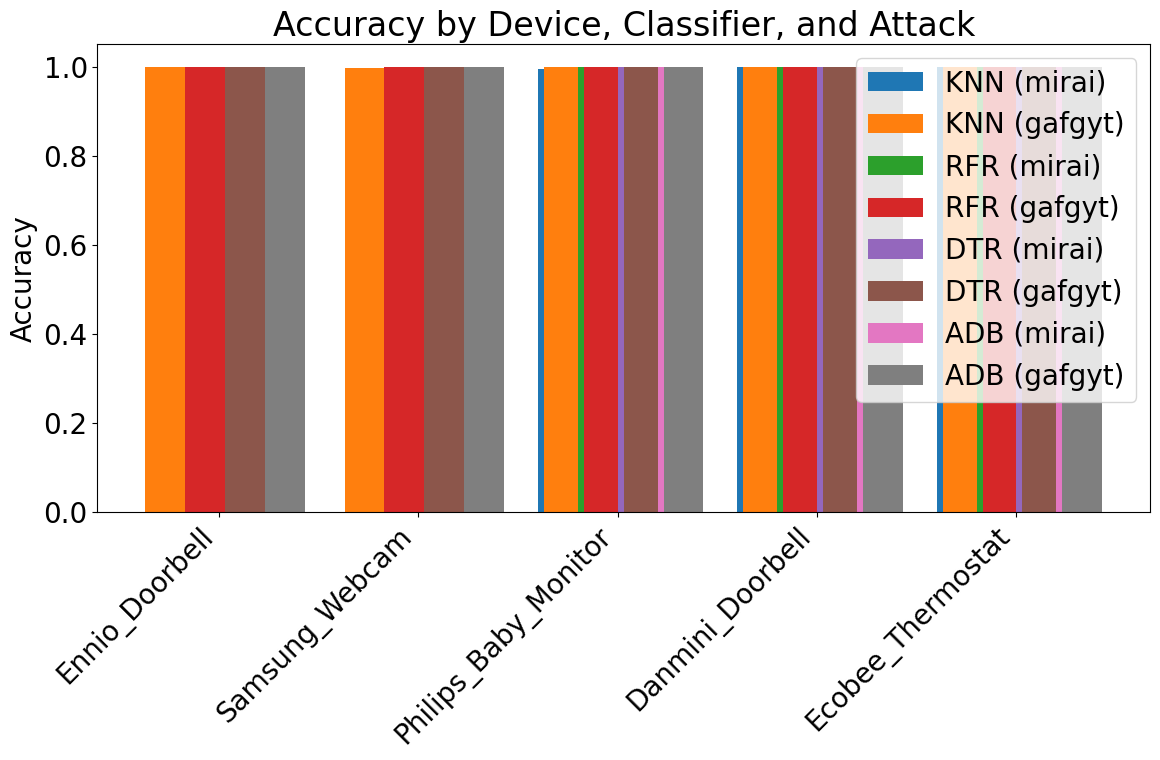

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_results contains the data you provided
# Each row: ['DEVICE','BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'RECALL', 'F1-SCORE', 'FALSE-P', 'FALSE-N']

devices = set(row[0] for row in all_results[1:])
classifiers = ['KNN', 'RFR', 'DTR', 'ADB']
attacks = set(row[1] for row in all_results[1:])

# Create a dictionary to store accuracies for each device, classifier, and attack
accuracies = {dev: {clf: {attack: [] for attack in attacks} for clf in classifiers} for dev in devices}

for row in all_results[1:]:
    device, botnet, clf, acc, _, _, _, _, _ = row
    accuracies[device][clf][botnet].append(acc)

# Prepare data for plotting
x = np.arange(len(devices))
width = 0.2

# Adjust the figsize parameter to make the graph taller
fig, ax = plt.subplots(figsize=(12, 8))

for clf_idx, clf in enumerate(classifiers):
    for attack_idx, attack in enumerate(attacks):
        acc_values = [np.mean(accuracies[dev][clf].get(attack, [])) for dev in devices]
        ax.bar(x + (clf_idx - 1.5 + attack_idx * 0.15) * width, acc_values, width, label=f"{clf} ({attack})")

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Device, Classifier, and Attack')
ax.set_xticks(x)
ax.set_xticklabels(devices, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


# graph for mirai and gafgyt

In [1]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming all_results contains the data you provided
# Each row: ['DEVICE','BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'RECALL', 'F1-SCORE', 'FALSE-P', 'FALSE-N']

devices = set(row[0] for row in all_results[1:])
classifiers = ['KNN', 'RFR', 'DTR', 'ADB']

# Create a dictionary to store accuracies for each device, classifier, and attack
accuracies = {dev: {clf: {attack: [] for attack in ["mirai", "gafgyt"]} for clf in classifiers} for dev in devices}

for row in all_results[1:]:
    device, botnet, clf, acc, _, _, _, _, _ = row
    if botnet in ["mirai", "gafgyt"]:
        accuracies[device][clf][botnet].append(acc)

# Prepare data for plotting
x = np.arange(len(devices))
width = 0.2

# Create subplots for mirai and gafgyt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for mirai
for clf_idx, clf in enumerate(classifiers):
    mirai_acc_values = [np.mean(accuracies[dev][clf]['mirai']) for dev in devices]
    ax1.bar(x + (clf_idx - 1.5) * width, mirai_acc_values, width, label=clf)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Device and Classifier (Mirai)')
ax1.set_xticks(x)
ax1.set_xticklabels(devices, rotation=45, ha='right')
ax1.legend()

# Plot for gafgyt
for clf_idx, clf in enumerate(classifiers):
    gafgyt_acc_values = [np.mean(accuracies[dev][clf]['gafgyt']) for dev in devices]
    ax2.bar(x + (clf_idx - 1.5) * width, gafgyt_acc_values, width, label=clf)
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy by Device and Classifier (Gafgyt)')
ax2.set_xticks(x)
ax2.set_xticklabels(devices, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.show()


NameError: name 'all_results' is not defined